In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit # shorthand for the sigmoid function
from sklearn.neural_network import MLPClassifier # a nonparametric classifier (other options could be SVM, Random Forest, etc.)
from sklearn.base import clone # for cloning sklearn models
from joblib import Parallel, delayed # for parallel processing
from pandas import json_normalize # shortand to flatten nested JSON objects
import seaborn as sns
import time
import datetime

In [2]:
def prob_death_under_no_ttt(X): return expit(np.sin(X))
def prob_death_under_ttt(X): return expit(0.5*np.sin(X)-.1)

In [3]:
def plot_prob_death(prec=1000):
    x = np.linspace(-1, 1, prec)
    y0 = prob_death_under_no_ttt(x)
    y1 = prob_death_under_ttt(x)
    plt.figure(figsize=(8, 8)) 
    plt.plot(x, y0, color='black', linewidth=3, linestyle='--', label='Probability of death when treatment is NOT given')
    plt.plot(x, y1, color='black', linewidth=3, label='Probability of death when treatment is given')
    plt.fill_between(x, y0, y1, where=(y1 >= y0), facecolor='red', alpha=1, interpolate=True, label='Treatment is harmful for these patients') 
    plt.fill_between(x, y0, y1, where=(y0 > y1), facecolor='green', alpha=1, interpolate=True, label='Treatment is beneficial for these patients') 
    plt.xlabel('X i.e., a patient characteristic')
    plt.ylabel('P(death|X, TTT) and P(death|X, no TTT)\ni.e., prognostic functions')
    plt.title('Simulated prognostic functions\nwhen treatment is given vs. not given')
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

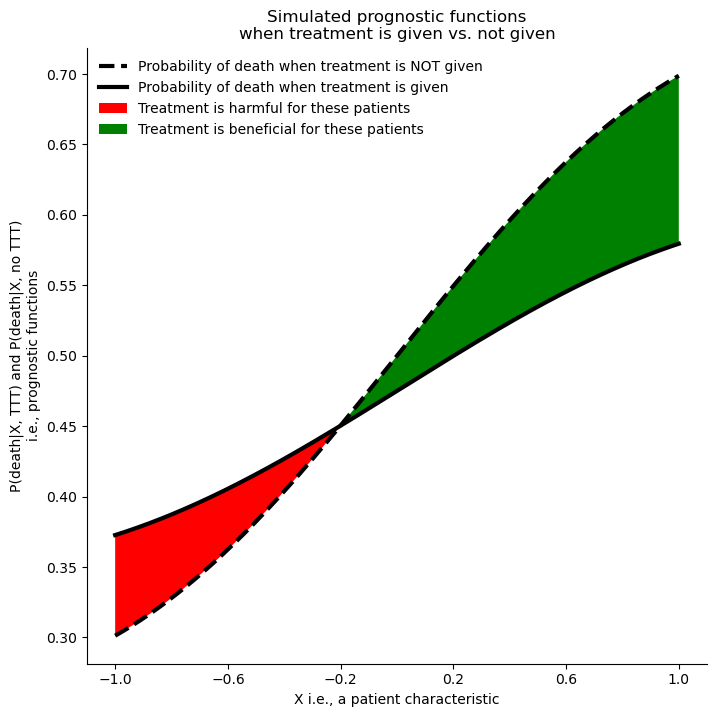

In [4]:
plot_prob_death()

In [5]:
def plot_individualized_ttt_effects(prec=100000):
    x = np.linspace(-1, 1, prec)
    y = prob_death_under_ttt(x) - prob_death_under_no_ttt(x)
    true_ate = np.mean(y)
    plt.figure(figsize=(7, 7)) 
    plt.axhline(0, color='black', linewidth=1, linestyle='--', label='Line of no treatment effect')
    plt.plot(x[y>=0], y[y>=0], color='red', linewidth=3, label='Treatment is harmful for these patients') 
    plt.plot(x[y<0], y[y<0], color='green', linewidth=3, label='Treatment is beneficial for these patients')
    plt.axhline(true_ate, color='black', linewidth=3, label=f'Average treatment effect ({true_ate*100:.2f}%)')
    plt.xlabel('X i.e., a patient characteristic')
    plt.ylabel('P(death|X, TTT) - P(death|X, no TTT)\ni.e., conditional treatment effect')
    plt.title('Simulated conditional treatment effects')
    plt.legend(frameon=False)
    plt.xticks(np.arange(-1, 1.1, 0.4))
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    return true_ate

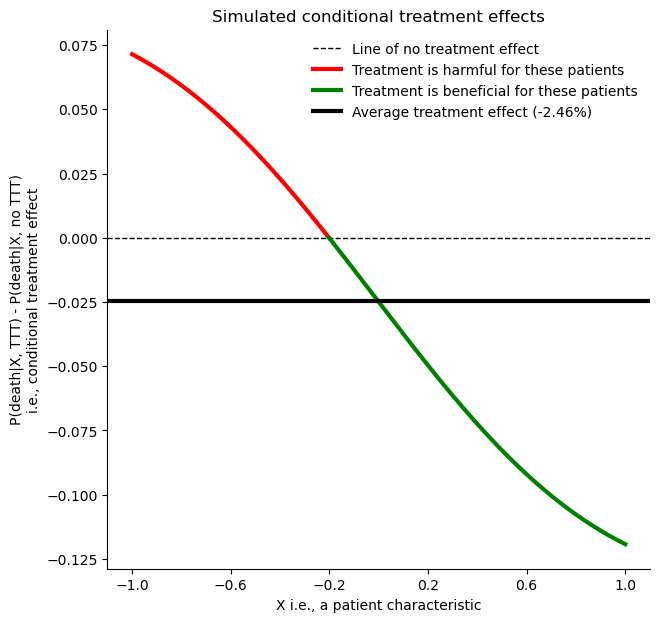

In [6]:
true_ate = plot_individualized_ttt_effects();

In [7]:
def generate_data(n_samples):
    # sample X from a uniform distribution
    X = np.random.uniform(-1,1, n_samples)

    # sample from a bernoulli distribution
    T = np.random.binomial(1, np.cos(X), n_samples)
    Y_t0 = np.random.binomial(1, prob_death_under_no_ttt(X), n_samples)
    Y_t1 = np.random.binomial(1, prob_death_under_ttt(X), n_samples)

    # apply the consistency assumption
    Y = T * Y_t1 + (1-T) * Y_t0
    
    return pd.DataFrame({'X': X, 'T': T, 'Y': Y, 'Y_t0': Y_t0, 'Y_t1': Y_t1})
    

In [8]:
# test the function
super_population = generate_data(10000)

# print the first few rows of the dataframe rounded to 2 decimal places
super_population.round(2).head()

,X,T,Y,Y_t0,Y_t1
0,0.18,1,0,0,0
1,0.06,1,1,0,1
2,-0.73,1,0,0,0
3,-0.62,0,1,1,0
4,-0.10,1,1,1,1


In [9]:
def g_comp_ate_estimator(data, sk_model):
    # Prepare prognostic models for T == 1 and T == 0
    pr_model_t1 = clone(sk_model)
    pr_model_t0 = clone(sk_model)
    
    # Get inputs and targets for T == 1 (i.e., subgroup where treatment is given)
    inputs_t1 = data["X"][data["T"]==1].values.reshape(-1, 1)
    targets_t1 = data["Y"][data["T"]==1]
    
    # Fit the model for the subgroup where treatment is given
    pr_model_t1.fit(inputs_t1, targets_t1)

    # For all patients, predict probabilities of death if the treatment were given
    predicted_proba_t1 = pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Get inputs and targets for T == 0 (i.e., subgroup where treatment is not given)
    inputs_t0 = data["X"][data["T"]==0].values.reshape(-1, 1)
    targets_t0 = data["Y"][data["T"]==0].values
    
    # Fit the model for the subgroup where treatment is NOT given
    pr_model_t0.fit(inputs_t0, targets_t0)
    
    # For all patients, predict probabilities of death if the treatment were NOT given
    predicted_proba_t0 = pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Compute the g-computation estimate of the ATE
    gcomp_ate_estimate = np.mean(predicted_proba_t1 - predicted_proba_t0)
    return gcomp_ate_estimate, pr_model_t1, pr_model_t0

In [10]:
# take a sample of size 10000 from the super_population
data = super_population.iloc[:1000, :3]

# Instantiate a nonparametric classifier (multi-layer perceptron with 2 hidden units here but could be any other model)
mlp_model = MLPClassifier(hidden_layer_sizes=(20), activation="logistic", solver="lbfgs", max_iter=5000, random_state=42)

# test the estimator function
g_comp_ate_estimator(data, mlp_model)

(np.float64(0.01980285041060393),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'))

In [11]:
def ipw_ate_estimator(data, sk_model):
    # Prepare the propensity score model P(T=1|X)
    ps_model = clone(sk_model)
    
    # Get inputs and targets for the propensity score model
    inputs = data["X"].values.reshape(-1, 1)
    targets = data["T"]
    
    # Fit the propensity score model P(T=1|X)
    ps_model.fit(inputs, targets)

    # For all patients, predict probabilities of receiving treatment
    predicted_proba = ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    
    # Calculate the weights of the treated as the inverse probabilty of being treated
    w_t1 = data["T"] / predicted_proba
    
    # Calculate the weights of the untreated as the inverse probabilty of being NOT being treated 
    w_t0 = (1 - data["T"]) / (1 - predicted_proba)
    
    # Compute the IPW estimate of the ATE
    ipw_ate_estimate = np.mean((w_t1 - w_t0) * data["Y"])
    
    # Normalize the weights
    w_t1_normalized = w_t1 / np.sum(w_t1)
    w_t0_normalized = w_t0 / np.sum(w_t0)
    
    # Compute the IPW estimate of the ATE using normalized weights
    ipw_ate_estimate_normalized = np.sum((w_t1_normalized - w_t0_normalized) * data["Y"])
    
    return ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model

In [12]:
#test the estimator function
ipw_ate_estimator(data, mlp_model)

(np.float64(0.08521530551476175),
 np.float64(0.03216385569218311),
 MLPClassifier(activation='logistic', hidden_layer_sizes=20, max_iter=5000,
               random_state=42, solver='lbfgs'))

In [13]:
# We can obtain estimates and fitted models from our functions as follows
gcomp_ate_estimate, pr_model_t1, pr_model_t0 = g_comp_ate_estimator(data, mlp_model)
ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model = ipw_ate_estimator(data, mlp_model)

In [14]:
def aipw_ate_estimator(data, gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model):
    top_left = 2 * data["T"] - 1
    pr_model_preds = data["T"] * pr_model_t1.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * pr_model_t0.predict_proba(data["X"].values.reshape(-1, 1))[:,1]
    top_right = data["Y"] - pr_model_preds
    denominator = data["T"] * ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1] + (1 - data["T"]) * (1 - ps_model.predict_proba(data["X"].values.reshape(-1, 1))[:,1])
    correction_term = top_left * top_right / denominator
    aipw_ate_estimate = gcomp_ate_estimate + np.mean(correction_term)
    return aipw_ate_estimate

In [15]:
def apply_estimators(data, sk_model):
    """
    Input:
    - data: a pandas dataframe containing the data with columns X, T, and Y
    - sk_model: an instance of a scikit-learn classifier
    Output:
    - gcomp_ate_estimate: the g-computation estimate of the ATE
    - ipw_ate_estimate: the IPW estimate of the ATE
    - ipw_ate_estimate_normalized: the IPW estimate of the ATE using normalized weights
    - aipw_ate_estimate: the AIPW estimate of the ATE
    """
    gcomp_ate_estimate, pr_model_t1, pr_model_t0 = g_comp_ate_estimator(data, sk_model)
    ipw_ate_estimate, ipw_ate_estimate_normalized, ps_model = ipw_ate_estimator(data, sk_model)
    aipw_ate_estimate = aipw_ate_estimator(data, gcomp_ate_estimate, pr_model_t1, pr_model_t0, ps_model)
    return gcomp_ate_estimate, ipw_ate_estimate, ipw_ate_estimate_normalized, aipw_ate_estimate

In [16]:
class Simulation:
    def __init__(self, s_size, n_sim, generate_data, true_ate, sk_model):
        self.s_size = s_size
        self.n_sim = n_sim
        self.generate_data = generate_data
        self.true_ate = true_ate
        self.sk_model = sk_model
    
    def sim_superpop_and_idxs(self):
        # Create a superpopulation that of size s_size*n_sim
        self.superpop = self.generate_data(self.s_size * self.n_sim)[["X", "T", "Y"]]

        # Create a list of lists of indices for the simulations
        self.sim_idx_s = [range(it * self.s_size, it * self.s_size + self.s_size) for it in range(self.n_sim)]
        self.sim_idx_s = list(map(list, self.sim_idx_s))
        # sim_idx_s is of the form [[0, 1,.., s_size-1], [s_size, s_size+1,.., 2*s_size-1], ...]

        # Confirm that the superpopulation is large enough for the simulation size
        assert self.sim_idx_s[-1][-1] < self.superpop.shape[0], "The dataset is too small for the simulation size (sample size * number of simulations)"
        
    def run_one_simulation(self, sim_idx):
        # Prepare the data for the simulation iteration
        data = self.superpop.iloc[sim_idx]
        gcomp, ipw, ipw_normalized, aipw = apply_estimators(data, self.sk_model)
        
        # Save the results by appending a new row to the results dataframe
        iteration_result = {"iteration": sim_idx[0]//len(sim_idx),
                            "gcomp": gcomp,
                            "ipw": ipw,
                            "ipw_normalized": ipw_normalized,
                            "aipw": aipw}
        return iteration_result

    def run_all_simulations(self):
        # Run all simulations in parallel
        self.results = Parallel(n_jobs=-1)(delayed(self.run_one_simulation)(sim_idx) for sim_idx in self.sim_idx_s)
        # Save the results in a dataframe
        self.results = pd.DataFrame(self.results)
    
    def process_results(self):
        # Calulate bias, variance, MSE and coverage
        estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
        mse = (self.results[estimators] - self.true_ate).pow(2).mean(axis=0)
        bias = self.results[estimators].mean(axis=0) - self.true_ate
        variance = self.results[estimators].var(axis=0) # this is normalized by N-1 by default
        self.analyzed_results = {"n_sim": self.n_sim, "s_size": self.s_size, "mse": dict(mse), "bias": dict(bias), "variance": dict(variance)}

In [17]:
sim_instance = Simulation(s_size=200, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
sim_instance.sim_superpop_and_idxs()
sim_instance.run_one_simulation(sim_instance.sim_idx_s[0])

{'iteration': 0,
 'gcomp': np.float64(0.1846649463955928),
 'ipw': np.float64(0.38381658278198844),
 'ipw_normalized': np.float64(0.26044627750520477),
 'aipw': np.float64(0.22130606322021693)}

In [20]:
sim_instance.run_one_simulation(sim_instance.sim_idx_s[1])

{'iteration': 1,
 'gcomp': np.float64(-0.17409468895526423),
 'ipw': np.float64(0.07482435522487635),
 'ipw_normalized': np.float64(-0.14134528383684614),
 'aipw': np.float64(-0.1997464407083018)}

In [21]:
sim_instance.run_all_simulations()

/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/py

In [22]:
sim_instance.results

,iteration,gcomp,ipw,ipw_normalized,aipw
0,0,0.184665,0.383817,0.260446,0.221306
1,1,-0.174095,0.074824,-0.141345,-0.199746
2,2,0.001385,0.102675,-0.094036,-0.002223
3,3,0.059708,0.270254,0.060184,0.066753
4,4,-0.003202,0.155925,-0.092082,0.010254
...,...,...,...,...,...
994,994,-0.014002,0.136009,-0.059082,-0.013881
995,995,0.072978,0.241996,0.181268,0.093085
996,996,-0.172004,0.067063,-0.213301,-0.193720
997,997,-0.228716,0.064091,-0.137449,-0.227708


In [23]:
sim_instance.process_results()
sim_instance.analyzed_results

{'n_sim': 999,
 's_size': 200,
 'mse': {'gcomp': np.float64(0.023533613948598014),
  'ipw': np.float64(0.04723115891691668),
  'ipw_normalized': np.float64(0.016564474162401647),
  'aipw': np.float64(0.024089688101746037)},
 'bias': {'gcomp': np.float64(-0.0004624187838734341),
  'ipw': np.float64(0.18461872058566645),
  'ipw_normalized': np.float64(-0.009496112710599039),
  'aipw': np.float64(-0.0006875257275885081)},
 'variance': {'gcomp': np.float64(0.023556980678706284),
  'ipw': np.float64(0.013160260360022123),
  'ipw_normalized': np.float64(0.016490805318420294),
  'aipw': np.float64(0.024113352900510837)}}

In [24]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, verbose=False)
s_sizes = np.logspace(np.log10(500), np.log10(20000), num=5, dtype=int) + 1 
s_sizes


array([  500,  1258,  3163,  7953, 20001])

In [25]:
all_results = []

sim_start_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Starting simulation at {sim_start_time}\n")
for s_size in s_sizes:
    start_time = time.time()
    print(f"Running simulations for sample size n={s_size}...\n")
    
    sim = Simulation(s_size=s_size, n_sim=999, generate_data=generate_data, true_ate=true_ate, sk_model=mlp_model)
    sim.sim_superpop_and_idxs()
    sim.run_all_simulations()
    sim.process_results()
    all_results.append(sim)
    
    end_time = time.time()
    hours, rem = divmod(end_time - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"... took {int(hours)}h {int(minutes)}m {seconds:.1f}s\n")
        
sim_end_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(f"Simulation finished at {sim_end_time}")

Starting simulation at 2024-12-02-21-40-35

Running simulations for sample size n=500...

... took 0h 0m 18.3s

Running simulations for sample size n=1258...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 0m 32.1s

Running simulations for sample size n=3163...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 0m 52.8s

Running simulations for sample size n=7953...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 2m 0.6s

Running simulations for sample size n=20001...



/Users/grolleau/Desktop/github_repos/causal_inference_tuto/.conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


... took 0h 5m 15.7s

Simulation finished at 2024-12-02-21-49-34


In [181]:
xx = ["-0.24%", "0.26%"]
[x[1:-1] if x[0] == "-" else x[:-1] for x in xx]

['0.24', '0.26']

In [163]:
results_df = json_normalize([sim.analyzed_results for sim in all_results])
results_df.columns = [col.replace('.', '_') for col in results_df.columns]
results_df

,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.003907,0.014867,0.005774,0.005431,0.005803,0.102087,0.003051,0.004589,0.003877,0.004450,0.005770,0.005415
1,999,1258,0.001544,0.008851,0.002447,0.002210,0.004806,0.081908,0.001286,0.002633,0.001523,0.002144,0.002448,0.002205
2,999,3163,0.000597,0.005684,0.001047,0.000979,0.002303,0.068567,0.001291,0.002053,0.000592,0.000984,0.001047,0.000975
3,999,7953,0.000279,0.004443,0.000430,0.000408,0.000843,0.059676,-0.000308,0.000277,0.000278,0.000883,0.000430,0.000408
4,999,20001,0.000159,0.004028,0.000186,0.000176,0.000766,0.057588,-0.000112,0.000499,0.000159,0.000712,0.000186,0.000176


In [ ]:
# This is NOT human readeable but does not matter as it just serves to color the table
# which is not particularly insightful

def highlight_cells(x):
    # Create an empty DataFrame with the same shape as x
    df = pd.DataFrame('', index=x.index, columns=x.columns)
    
    # Apply the mask only to numeric columns
    df.iloc[:, 2:] = 'background-color: gray'
    for col in x.columns:
        if "bias" in col:
            df.loc[:, col] = 'background-color: darkgray'
        for metric in ["mse", "bias", "variance"]:
            if metric in col:
                # gymastic below to remove minus signs as appropriate and compare color the winner estimators in green
                mask = x[col].apply(lambda x: x[1:-1] if x[0] == "-" else x[:-1]) == results_df[[f"{metric}_gcomp", f"{metric}_ipw", f"{metric}_ipw_normalized", f"{metric}_aipw"]].apply(lambda xx: min([x[1:-1] if x[0] == "-" else x[:-1] for x in xx]), axis=1)
                df.loc[mask, col] = 'background-color: green'
        
    return df

# Define a custom function to format the values
def format_percentage(x):
    if isinstance(x, float):
        return f"{x * 100:.2f}%"
    return x

# Apply the custom function to all but the first two columns
results_df.iloc[:, 2:] = results_df.iloc[:, 2:].map(format_percentage)

# Apply the custom function to the DataFrame
styled_results_df = results_df.style.apply(highlight_cells, axis=None)

styled_results_df



,n_sim,s_size,mse_gcomp,mse_ipw,mse_ipw_normalized,mse_aipw,bias_gcomp,bias_ipw,bias_ipw_normalized,bias_aipw,variance_gcomp,variance_ipw,variance_ipw_normalized,variance_aipw
0,999,500,0.39%,1.49%,0.58%,0.54%,0.58%,10.21%,0.31%,0.46%,0.39%,0.44%,0.58%,0.54%
1,999,1258,0.15%,0.89%,0.24%,0.22%,0.48%,8.19%,0.13%,0.26%,0.15%,0.21%,0.24%,0.22%
2,999,3163,0.06%,0.57%,0.10%,0.10%,0.23%,6.86%,0.13%,0.21%,0.06%,0.10%,0.10%,0.10%
3,999,7953,0.03%,0.44%,0.04%,0.04%,0.08%,5.97%,-0.03%,0.03%,0.03%,0.09%,0.04%,0.04%
4,999,20001,0.02%,0.40%,0.02%,0.02%,0.08%,5.76%,-0.01%,0.05%,0.02%,0.07%,0.02%,0.02%


In [156]:
# Prepare the data for visualization
# (this part is a bit convoluted and not particulary insighful)
estimators = ["gcomp", "ipw", "ipw_normalized", "aipw"]
estimates = pd.concat([pd.concat([all_results[i].results[estimator] for estimator in estimators]) for i in range(len(all_results))])
repeated_estimators = [item for item in estimators for _ in range(all_results[0].n_sim)]
repeated_estimators = repeated_estimators * len(all_results)
repeated_s_sizes = [[s_size] * all_results[0].n_sim * len(estimators) for s_size in s_sizes]
repeated_s_sizes = [item for sublist in repeated_s_sizes for item in sublist]
len(repeated_s_sizes), len(repeated_estimators), len(estimates)
# put the results in a dataframe
results_df = pd.DataFrame({"Estimators": repeated_estimators, "Sample Size": repeated_s_sizes, "Estimations": estimates})
results_df['Estimators'] = results_df['Estimators'].replace({
    'gcomp': 'G-computation',
    'ipw': 'IPW',
    'ipw_normalized': 'normalized IPW',
    'aipw': 'AIPW'
})

In [28]:
def plot_violin(results_df, true_ate):
    plt.figure(figsize=(12, 8))
    plt.grid(axis='y', linestyle='--', linewidth=0.7)

    unique_sample_sizes = results_df['Sample Size'].unique()
    custom_palette = {size: color for size, color in zip(unique_sample_sizes, sns.color_palette("colorblind", len(unique_sample_sizes)))}

    sns.violinplot(x='Estimators', y='Estimations', hue='Sample Size', data=results_df, split=False, palette=custom_palette)
    plt.axhline(y=true_ate, color='red', linewidth=3, label='True ATE')
    plt.legend(title='Sample Size', frameon=False)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.title(f'Average Treatment Effect Estimators\nComputed for {all_results[0].n_sim} Simulation Iterations', fontsize=16)
    plt.xlabel('Estimators', fontsize=14)
    plt.ylabel('Estimations', fontsize=14)

    plt.show()

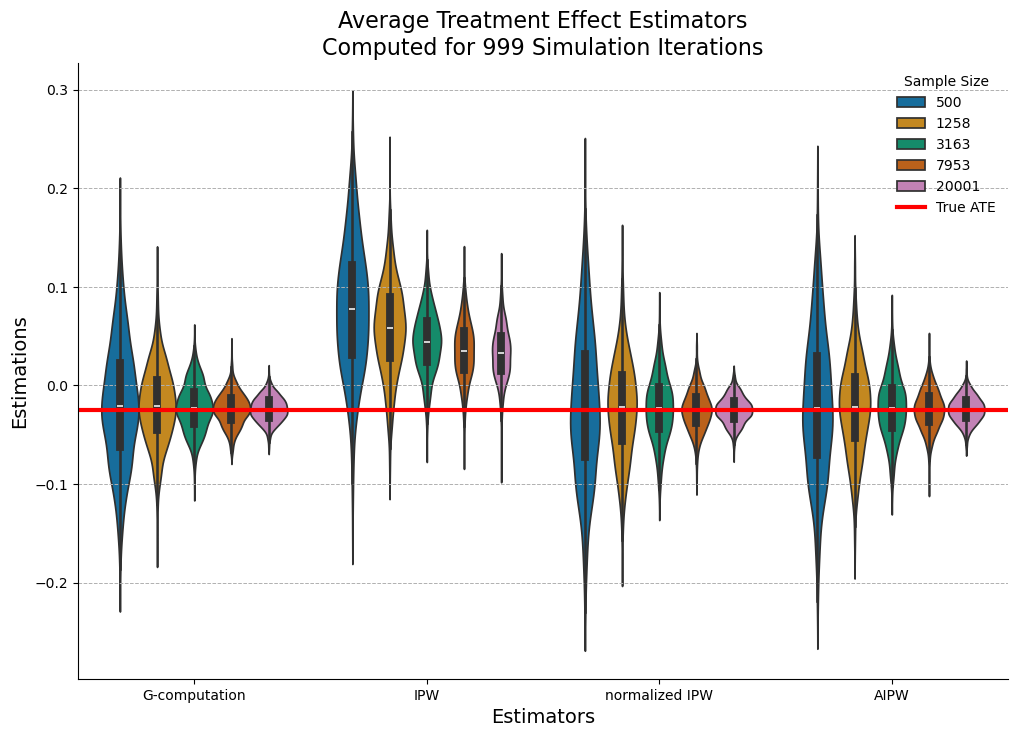

In [29]:
plot_violin(results_df, true_ate);